# CISC 873 Data Mining Competition 3 (Reddit Fake Post Detection - NLP)

## Questions

### What is the difference between Character n-gram and Word n-gram? Which one tends to suffer more from the OOV issue?

- Character n-gram divides text into sequences of characters, while word n-gram divides text into sequences of words.
- Word n-gram tends to suffer more from the OOV (out-of-vocabulary) issue because it requires a larger vocabulary to cover all possible combinations of words.

### What is the difference between stop word removal and stemming? Are these techniques language-dependent?

- Stopword removal involves removing commonly used words that do not contribute much to the meaning of the text, while stemming involves reducing words to their root form. 
- These techniques are language-dependent as the stopwords and stemming rules may vary depending on the language.

### Is tokenization techniques language dependent? Why?

- Tokenization techniques are language-dependent Because different languages may have different word boundaries and punctuation rules.

### What is the difference between count vectorizer and tf-idf vectorizer? Would it be feasible to use all possible n-grams? If not, how should you select them?

- Count vectorizer represents each document as a vector of counts of each n-gram, while tf-idf vectorizer represents each document as a vector of weighted counts of each n-gram.
- It would not be feasible to use all possible n-grams as the vocabulary size would be too large.
- Instead, we can select a subset of n-grams based on their frequency or information gain.

## Overview

### Define the problem

Predict whether a given Reddit post title is fake news or not.

### What is the input?

The input is a Reddit post title

### What is the output?

The output is a binary label indicating whether the post is fake news (1) or not (0).

### What data mining function is required?

The data mining function required is Text binary classification

### What could be the challenges?

The challenges include:
- dealing with raw text data.
- selecting the appropriate text preprocessing techniques.
- selecting the appropriate machine learning algorithms.

---

***

## Imports Libraries

### - common libraries

In [1]:
import re
import pandas as pd
import numpy as np

import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
%matplotlib inline

seed = 72
np.random.seed(seed)

pd.set_option('display.max_rows', 150)

### - nlp processing

In [2]:
import nltk 
from nltk.stem.snowball import EnglishStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\adham\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### - sklearn

In [96]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, PredefinedSplit

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline

# models
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn import set_config
set_config(display="diagram")

For dealing with text related tasks, we will be using [nltk](https://www.nltk.org). The terrific [scikit-learn](https://scikit-learn.org/) library will be used to handle tasks related to machine learning.  
Now, we can take a peek into the data:

## Read data set

In [4]:
# Read training data
data = pd.read_csv('xy_train.csv')
data

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0
...,...,...,...
59995,70046,Finish Sniper Simo H盲yh盲 during the invasion o...,0
59996,189377,Nigerian Prince Scam took $110K from Kansas ma...,1
59997,93486,Is It Safe To Smoke Marijuana During Pregnancy...,0
59998,140950,Julius Caesar upon realizing that everyone in ...,0


In [5]:
# the data frame is quite large. we use part of it in this lab:
# df = data.sample(10000)
# work on all the data
df = data.copy()
df

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0
...,...,...,...
59995,70046,Finish Sniper Simo H盲yh盲 during the invasion o...,0
59996,189377,Nigerian Prince Scam took $110K from Kansas ma...,1
59997,93486,Is It Safe To Smoke Marijuana During Pregnancy...,0
59998,140950,Julius Caesar upon realizing that everyone in ...,0


## Data Visualization

In [6]:
# display the classes balance
df.label.value_counts()

label
0    32172
1    27596
2      232
Name: count, dtype: int64

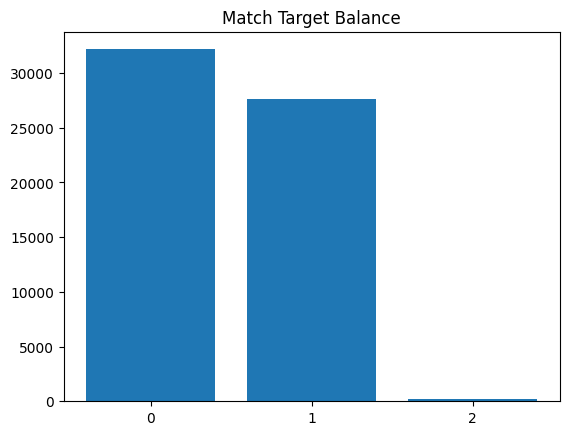

In [7]:
plt.bar(df.label.unique(), df.label.value_counts())
# make axis as discrete values
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Match Target Balance')
plt.show()

In [8]:
# display data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60000 non-null  int64 
 1   text    60000 non-null  object
 2   label   60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


## Cleaning, Pre-Processing and Post-Processing

### Preprocessing

#### Drop Missclassified data
data with label not equal 0 or 1

In [9]:
df = df[df.label != 2].copy()
df.label.value_counts()

label
0    32172
1    27596
Name: count, dtype: int64

#### Drop unused columns
drop id column

In [10]:
df.drop(columns=['id'], inplace=True)

#### Check Missing Values
there is no any missing values

In [11]:
df.isnull().sum()

text     0
label    0
dtype: int64

#### Check Duplications
there are some duplicated rows and we will drop them

In [12]:
df.duplicated().sum()

345

In [13]:
df.drop_duplicates(inplace=True)

### Cleaning

#### Stopwords
get stopwords from many resources and use them together

In [14]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords as nltk_sw
import spacy

In [15]:
# Load the English language model in spaCy
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = nlp.Defaults.stop_words

In [16]:
nltk_stopwords = nltk_sw.words('english')

In [17]:
stopwords = list(ENGLISH_STOP_WORDS) + list(spacy_stopwords) + list(STOPWORDS) + nltk_stopwords
print(len(stopwords))
stopwords = list(set(stopwords))
print(len(stopwords))

1160
412


##### cleaning stopwords

In [18]:
def remove_punctuation(word):
    return re.sub('[^\sa-zA-Z]', '', word)

stopwords = [remove_punctuation(word) for word in stopwords ]

#### lemmatization and Stemming process

In [19]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

lemmatizer = WordNetLemmatizer()
def lemmatize(words):
    lemmas = []
    pos_tags = nltk.pos_tag(words)
    for token, pos in pos_tags:
        wordnet_pos = get_wordnet_pos(pos)
        lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmas.append(lemma)
    return lemmas

def lemmatize_word(word):
    pos_tags = nltk.pos_tag([word])
    for token, pos in pos_tags:
        wordnet_pos = get_wordnet_pos(pos)
        lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
    return lemma

# stemmer = EnglishStemmer()
stemmer = SnowballStemmer("english")
def stemming(words):
    stems = []
    for word in words:
        word = stemmer.stem(word)
        stems.append(word)
    return stems

In [20]:
stemming(['group', 'friends', 'began'])

['group', 'friend', 'began']

In [21]:
lemmatize(['group', 'friends', 'begin'])

['group', 'friends', 'begin']

In [22]:
lemmatize_word('writing')

'write'

In [23]:
stemming(lemmatize(['group', 'friends', 'begin']))

['group', 'friend', 'begin']

#### User defined Functions

In [24]:
joinUDF = lambda words: ' '.join(words)

removeSpecialCasesUDF = lambda words: [word for word in words if not (('@' in word) | ('www' in word) | ('http' in word))]

removeStopWordsUDF = lambda words: [word for word in words if not ((word in stopwords) | (len(word) < 3) | ('\t' in word) | ('\n' in word) | ('\r' in word) | ('\f' in word) | ('\b' in word))]  

removePunctuationUDF = lambda words: re.sub('[^\sa-zA-Z]', ' ', words)

lemmaUDF = lambda words: lemmatize(words)

stemUDF = lambda words: stemming(words)

In [25]:
displayed_row = 0
print("Cleaning and parsing the tweets...\n")

Cleaning and parsing the tweets...



#### Try my custom cleaning steps
trying them step by step and disply the output to explain the approach

#### Take A copy

In [26]:
df1 = df.copy()

##### 1. Convert data to lowercase

In [27]:
df1.text = df1.text.str.lower()
print(df1.text.iloc[displayed_row])

a group of friends began to volunteer at a homeless shelter after their neighbors protested. "seeing another person who鈥檚 also in need, you should just naturally be like, 鈥業 want to help that person.鈥?	0.84	1	0	0
neomegaryumkii	denmark just trolled trump with a bus watch what happens when it moves	1489962542.0	archive.is	true	60cu90	https://external-preview.redd.it/s8hqxowdwn2pt3eebjiqetmgxvvmbbxad93w08lgzrs.jpg?width=320&crop=smart&auto=webp&s=46f0ad18132126cab9823da4f3a6d6ec3a281bb2		5.0	36	savedyouaclick	denmark just trolled trump with a bus. watch what happens when it moves | back wheels look like eyes that spin crazily as the bus moves (saved a click + short video that goes into slow motion (video mirror in comments since archive removed it))	0.92	0	2	5
atbthefirst	young man theres no need to feel down	1429563057.0		true	cqiw655	http://i.imgur.com/rxtkm4u.jpg	338ute		6	psbattle_artwork	young man, there's no need to feel down		0	2	4
beosronlto	my onion ring chimp	1491483860.0	imgur

##### 2. Split text to words (Tokenize)

In [28]:
df1.text = df1.text.str.split(' ')
print(df1.text.iloc[displayed_row])

['a', 'group', 'of', 'friends', 'began', 'to', 'volunteer', 'at', 'a', 'homeless', 'shelter', 'after', 'their', 'neighbors', 'protested.', '"seeing', 'another', 'person', 'who鈥檚', 'also', 'in', 'need,', 'you', 'should', 'just', 'naturally', 'be', 'like,', '鈥業', 'want', 'to', 'help', 'that', 'person.鈥?\t0.84\t1\t0\t0\nneomegaryumkii\tdenmark', 'just', 'trolled', 'trump', 'with', 'a', 'bus', 'watch', 'what', 'happens', 'when', 'it', 'moves\t1489962542.0\tarchive.is\ttrue\t60cu90\thttps://external-preview.redd.it/s8hqxowdwn2pt3eebjiqetmgxvvmbbxad93w08lgzrs.jpg?width=320&crop=smart&auto=webp&s=46f0ad18132126cab9823da4f3a6d6ec3a281bb2\t\t5.0\t36\tsavedyouaclick\tdenmark', 'just', 'trolled', 'trump', 'with', 'a', 'bus.', 'watch', 'what', 'happens', 'when', 'it', 'moves', '|', 'back', 'wheels', 'look', 'like', 'eyes', 'that', 'spin', 'crazily', 'as', 'the', 'bus', 'moves', '(saved', 'a', 'click', '+', 'short', 'video', 'that', 'goes', 'into', 'slow', 'motion', '(video', 'mirror', 'in', 'comme

##### 3. Remove Special Cases
- urls start with http
- tags start with @
- links start with www

In [29]:
df1.text = df1.text.apply(removeSpecialCasesUDF)
print(df1.text.iloc[displayed_row])

['a', 'group', 'of', 'friends', 'began', 'to', 'volunteer', 'at', 'a', 'homeless', 'shelter', 'after', 'their', 'neighbors', 'protested.', '"seeing', 'another', 'person', 'who鈥檚', 'also', 'in', 'need,', 'you', 'should', 'just', 'naturally', 'be', 'like,', '鈥業', 'want', 'to', 'help', 'that', 'person.鈥?\t0.84\t1\t0\t0\nneomegaryumkii\tdenmark', 'just', 'trolled', 'trump', 'with', 'a', 'bus', 'watch', 'what', 'happens', 'when', 'it', 'just', 'trolled', 'trump', 'with', 'a', 'bus.', 'watch', 'what', 'happens', 'when', 'it', 'moves', '|', 'back', 'wheels', 'look', 'like', 'eyes', 'that', 'spin', 'crazily', 'as', 'the', 'bus', 'moves', '(saved', 'a', 'click', '+', 'short', 'video', 'that', 'goes', 'into', 'slow', 'motion', '(video', 'mirror', 'in', 'comments', 'since', 'archive', 'removed', 'it))\t0.92\t0\t2\t5\natbthefirst\tyoung', 'man', 'theres', 'no', 'need', 'to', 'feel', 'man,', "there's", 'no', 'need', 'to', 'feel', 'down\t\t0\t2\t4\nbeosronlto\tmy', 'onion', 'ring', 'onion', 'ring', 

##### 4. Join the words again for more preprocessing

In [30]:
df1.text = df1.text.apply(joinUDF)
print(df1.text.iloc[displayed_row])

a group of friends began to volunteer at a homeless shelter after their neighbors protested. "seeing another person who鈥檚 also in need, you should just naturally be like, 鈥業 want to help that person.鈥?	0.84	1	0	0
neomegaryumkii	denmark just trolled trump with a bus watch what happens when it just trolled trump with a bus. watch what happens when it moves | back wheels look like eyes that spin crazily as the bus moves (saved a click + short video that goes into slow motion (video mirror in comments since archive removed it))	0.92	0	2	5
atbthefirst	young man theres no need to feel man, there's no need to feel down		0	2	4
beosronlto	my onion ring onion ring chimp	0.63	0	2	2
food_ss	this is what we eat in the images is what we eat in the images description)	0.84	0	2	3
cardboardsoyuz	arizona man purchases home and discovers an underground hatch in man purchases home and discovers an underground hatch in backyard | it leads to an old fall-out shelter in pretty good shape. it had a couple of 

##### 5. Remove Punctuations

In [31]:
df1.text = df1.text.apply(removePunctuationUDF)
print(df1.text.iloc[displayed_row])

a group of friends began to volunteer at a homeless shelter after their neighbors protested   seeing another person who   also in need  you should just naturally be like     want to help that person   	    	 	 	 
neomegaryumkii	denmark just trolled trump with a bus watch what happens when it just trolled trump with a bus  watch what happens when it moves   back wheels look like eyes that spin crazily as the bus moves  saved a click   short video that goes into slow motion  video mirror in comments since archive removed it  	    	 	 	 
atbthefirst	young man theres no need to feel man  there s no need to feel down		 	 	 
beosronlto	my onion ring onion ring chimp	    	 	 	 
food ss	this is what we eat in the images is what we eat in the images description 	    	 	 	 
cardboardsoyuz	arizona man purchases home and discovers an underground hatch in man purchases home and discovers an underground hatch in backyard   it leads to an old fall out shelter in pretty good shape  it had a couple of 

##### 6. Split text to words (Tokenize)

In [32]:
df1.text = df1.text.str.split(' ')
print(df1.text.iloc[displayed_row])

['a', 'group', 'of', 'friends', 'began', 'to', 'volunteer', 'at', 'a', 'homeless', 'shelter', 'after', 'their', 'neighbors', 'protested', '', '', 'seeing', 'another', 'person', 'who', '', '', 'also', 'in', 'need', '', 'you', 'should', 'just', 'naturally', 'be', 'like', '', '', '', '', 'want', 'to', 'help', 'that', 'person', '', '', '\t', '', '', '', '\t', '\t', '\t', '\nneomegaryumkii\tdenmark', 'just', 'trolled', 'trump', 'with', 'a', 'bus', 'watch', 'what', 'happens', 'when', 'it', 'just', 'trolled', 'trump', 'with', 'a', 'bus', '', 'watch', 'what', 'happens', 'when', 'it', 'moves', '', '', 'back', 'wheels', 'look', 'like', 'eyes', 'that', 'spin', 'crazily', 'as', 'the', 'bus', 'moves', '', 'saved', 'a', 'click', '', '', 'short', 'video', 'that', 'goes', 'into', 'slow', 'motion', '', 'video', 'mirror', 'in', 'comments', 'since', 'archive', 'removed', 'it', '', '\t', '', '', '', '\t', '\t', '\t', '\natbthefirst\tyoung', 'man', 'theres', 'no', 'need', 'to', 'feel', 'man', '', 'there', 

##### 7. Remove Stopwords

In [33]:
df1.text = df1.text.apply(removeStopWordsUDF)
print(df1.text.iloc[displayed_row])

['group', 'friends', 'began', 'volunteer', 'homeless', 'shelter', 'neighbors', 'protested', 'seeing', 'person', 'need', 'naturally', 'like', 'want', 'help', 'person', 'trolled', 'trump', 'bus', 'watch', 'happens', 'trolled', 'trump', 'bus', 'watch', 'happens', 'moves', 'wheels', 'look', 'like', 'eyes', 'spin', 'crazily', 'bus', 'moves', 'saved', 'click', 'short', 'video', 'goes', 'slow', 'motion', 'video', 'mirror', 'comments', 'archive', 'removed', 'man', 'theres', 'need', 'feel', 'man', 'need', 'feel', 'onion', 'ring', 'onion', 'ring', 'eat', 'images', 'eat', 'images', 'description', 'man', 'purchases', 'home', 'discovers', 'underground', 'hatch', 'man', 'purchases', 'home', 'discovers', 'underground', 'hatch', 'backyard', 'leads', 'old', 'fall', 'shelter', 'pretty', 'good', 'shape', 'couple', 'cans', 'supplies', 'clicks', 'rpics', 'awards', 'spell', 'pics', 'awards', 'spell', 'traveller', 'assassin', 'attemps', 'obama', 'president', 'traveller', 'assassin', 'attemps', 'obama', 'pres

##### 8. Apply Lemmatization

In [34]:
df1.text = df1.text.apply(lemmaUDF)
print(df1.text.iloc[displayed_row])

['group', 'friends', 'begin', 'volunteer', 'homeless', 'shelter', 'neighbor', 'protest', 'see', 'person', 'need', 'naturally', 'like', 'want', 'help', 'person', 'troll', 'trump', 'bus', 'watch', 'happen', 'trolled', 'trump', 'bus', 'watch', 'happen', 'move', 'wheel', 'look', 'like', 'eye', 'spin', 'crazily', 'bus', 'move', 'save', 'click', 'short', 'video', 'go', 'slow', 'motion', 'video', 'mirror', 'comment', 'archive', 'remove', 'man', 'there', 'need', 'feel', 'man', 'need', 'feel', 'onion', 'ring', 'onion', 'ring', 'eat', 'image', 'eat', 'image', 'description', 'man', 'purchase', 'home', 'discovers', 'underground', 'hatch', 'man', 'purchase', 'home', 'discovers', 'underground', 'hatch', 'backyard', 'lead', 'old', 'fall', 'shelter', 'pretty', 'good', 'shape', 'couple', 'can', 'supply', 'click', 'rpics', 'award', 'spell', 'pic', 'award', 'spell', 'traveller', 'assassin', 'attemps', 'obama', 'president', 'traveller', 'assassin', 'attemps', 'obama', 'president', 'circa', 'state', 'fight

##### 9. Apply Stemmer

In [35]:
df1.text = df1.text.apply(stemUDF)
print(df1.text.iloc[displayed_row])

['group', 'friend', 'begin', 'volunt', 'homeless', 'shelter', 'neighbor', 'protest', 'see', 'person', 'need', 'natur', 'like', 'want', 'help', 'person', 'troll', 'trump', 'bus', 'watch', 'happen', 'troll', 'trump', 'bus', 'watch', 'happen', 'move', 'wheel', 'look', 'like', 'eye', 'spin', 'crazili', 'bus', 'move', 'save', 'click', 'short', 'video', 'go', 'slow', 'motion', 'video', 'mirror', 'comment', 'archiv', 'remov', 'man', 'there', 'need', 'feel', 'man', 'need', 'feel', 'onion', 'ring', 'onion', 'ring', 'eat', 'imag', 'eat', 'imag', 'descript', 'man', 'purchas', 'home', 'discov', 'underground', 'hatch', 'man', 'purchas', 'home', 'discov', 'underground', 'hatch', 'backyard', 'lead', 'old', 'fall', 'shelter', 'pretti', 'good', 'shape', 'coupl', 'can', 'suppli', 'click', 'rpic', 'award', 'spell', 'pic', 'award', 'spell', 'travel', 'assassin', 'attemp', 'obama', 'presid', 'travel', 'assassin', 'attemp', 'obama', 'presid', 'circa', 'state', 'fighter', 'reenter', 'ancient', 'palmyra', 'st

##### 10. Join the words again

In [36]:
df1.text = df1.text.apply(joinUDF)
print(df1.text.iloc[displayed_row])

group friend begin volunt homeless shelter neighbor protest see person need natur like want help person troll trump bus watch happen troll trump bus watch happen move wheel look like eye spin crazili bus move save click short video go slow motion video mirror comment archiv remov man there need feel man need feel onion ring onion ring eat imag eat imag descript man purchas home discov underground hatch man purchas home discov underground hatch backyard lead old fall shelter pretti good shape coupl can suppli click rpic award spell pic award spell travel assassin attemp obama presid travel assassin attemp obama presid circa state fighter reenter ancient palmyra state fighter enter ancient palmyra golf red line warn sign peopl get golf red line warn sign peopl get hurt nfls rate slide main fuel white viewer young nfl rate slide main fuel white viewer young streep streep marri articl say marri robert redford cactus cactus man stab debat iphon stab debat iphon samsung rid rid independ inde

In [37]:
print("Done Cleaning and parsing the tweets.\n")

Done Cleaning and parsing the tweets.



#### Try lab cleaning steps
trying them step by step and disply the output to explain the approach

#### Take A copy

In [38]:
df1 = df.copy()

In [39]:
RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
RE_TAGS = re.compile(r"<[^>]+>")
RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

##### 1. Remove Tags

In [40]:
df1.text = df1.text.apply(lambda text: re.sub(RE_TAGS, " ", text))
print(df1.text.iloc[displayed_row])

A group of friends began to volunteer at a homeless shelter after their neighbors protested. "Seeing another person who鈥檚 also in need, you should just naturally be like, 鈥業 want to help that person.鈥?	0.84	1	0	0
NeoMegaRyuMKII	denmark just trolled trump with a bus watch what happens when it moves	1489962542.0	archive.is	True	60cu90	https://external-preview.redd.it/s8HQxoWDwn2pt3eeBjIqetmGxvVMBBxaD93W08lGZrs.jpg?width=320&crop=smart&auto=webp&s=46f0ad18132126cab9823da4f3a6d6ec3a281bb2		5.0	36	savedyouaclick	Denmark Just Trolled Trump With A Bus. Watch What Happens When It Moves | Back wheels look like eyes that spin crazily as the bus moves (saved a click + short video that goes into slow motion (video mirror in comments since archive removed it))	0.92	0	2	5
atbthefirst	young man theres no need to feel down	1429563057.0		True	cqiw655	http://i.imgur.com/rxTKm4U.jpg	338ute		6	psbattle_artwork	Young man, there's no need to feel down		0	2	4
beosronlto	my onion ring chimp	1491483860.0	imgur

##### 2. Remove ASCII

In [41]:
df1.text = df1.text.apply(lambda text: re.sub(RE_ASCII, " ", text))
print(df1.text.iloc[displayed_row])

A group of friends began to volunteer at a homeless shelter after their neighbors protested   Seeing another person who   also in need  you should just naturally be like     want to help that person               NeoMegaRyuMKII denmark just trolled trump with a bus watch what happens when it moves              archive is True   cu   https   external preview redd it s HQxoWDwn pt eeBjIqetmGxvVMBBxaD  W  lGZrs jpg width     crop smart auto webp s   f ad        cab    da f a d ec a   bb          savedyouaclick Denmark Just Trolled Trump With A Bus  Watch What Happens When It Moves   Back wheels look like eyes that spin crazily as the bus moves  saved a click   short video that goes into slow motion  video mirror in comments since archive removed it              atbthefirst young man theres no need to feel down               True cqiw    http   i imgur com rxTKm U jpg    ute    psbattle artwork Young man  there s no need to feel down        beosronlto my onion ring chimp              imgur

##### 3. Remove Single Char

In [42]:
df1.text = df1.text.apply(lambda text: re.sub(RE_SINGLECHAR, " ", text))
print(df1.text.iloc[displayed_row])

  group of friends began to volunteer at   homeless shelter after their neighbors protested   Seeing another person who   also in need  you should just naturally be like     want to help that person               NeoMegaRyuMKII denmark just trolled trump with   bus watch what happens when it moves              archive is True   cu   https   external preview redd it   HQxoWDwn pt eeBjIqetmGxvVMBBxaD     lGZrs jpg width     crop smart auto webp       ad        cab    da       ec     bb          savedyouaclick Denmark Just Trolled Trump With   Bus  Watch What Happens When It Moves   Back wheels look like eyes that spin crazily as the bus moves  saved   click   short video that goes into slow motion  video mirror in comments since archive removed it              atbthefirst young man theres no need to feel down               True cqiw    http     imgur com rxTKm   jpg    ute    psbattle artwork Young man  there   no need to feel down        beosronlto my onion ring chimp              imgur

##### 4. Remove White Spaces

In [43]:
df1.text = df1.text.apply(lambda text: re.sub(RE_WSPACE, " ", text))
print(df1.text.iloc[displayed_row])

 group of friends began to volunteer at homeless shelter after their neighbors protested Seeing another person who also in need you should just naturally be like want to help that person NeoMegaRyuMKII denmark just trolled trump with bus watch what happens when it moves archive is True cu https external preview redd it HQxoWDwn pt eeBjIqetmGxvVMBBxaD lGZrs jpg width crop smart auto webp ad cab da ec bb savedyouaclick Denmark Just Trolled Trump With Bus Watch What Happens When It Moves Back wheels look like eyes that spin crazily as the bus moves saved click short video that goes into slow motion video mirror in comments since archive removed it atbthefirst young man theres no need to feel down True cqiw http imgur com rxTKm jpg ute psbattle artwork Young man there no need to feel down beosronlto my onion ring chimp imgur com True ss https external preview redd it muewXGrxJ YS iYpjqiBiXpIdxR Woyyln Xe jpg width crop smart auto webp bf aa dab dd ed pareidolia My onion ring chimp food SS 

##### 5. Split text to words (Tokenize)

In [44]:
df1.text = df1.text.apply(lambda text: word_tokenize(text))
print(df1.text.iloc[displayed_row])

['group', 'of', 'friends', 'began', 'to', 'volunteer', 'at', 'homeless', 'shelter', 'after', 'their', 'neighbors', 'protested', 'Seeing', 'another', 'person', 'who', 'also', 'in', 'need', 'you', 'should', 'just', 'naturally', 'be', 'like', 'want', 'to', 'help', 'that', 'person', 'NeoMegaRyuMKII', 'denmark', 'just', 'trolled', 'trump', 'with', 'bus', 'watch', 'what', 'happens', 'when', 'it', 'moves', 'archive', 'is', 'True', 'cu', 'https', 'external', 'preview', 'redd', 'it', 'HQxoWDwn', 'pt', 'eeBjIqetmGxvVMBBxaD', 'lGZrs', 'jpg', 'width', 'crop', 'smart', 'auto', 'webp', 'ad', 'cab', 'da', 'ec', 'bb', 'savedyouaclick', 'Denmark', 'Just', 'Trolled', 'Trump', 'With', 'Bus', 'Watch', 'What', 'Happens', 'When', 'It', 'Moves', 'Back', 'wheels', 'look', 'like', 'eyes', 'that', 'spin', 'crazily', 'as', 'the', 'bus', 'moves', 'saved', 'click', 'short', 'video', 'that', 'goes', 'into', 'slow', 'motion', 'video', 'mirror', 'in', 'comments', 'since', 'archive', 'removed', 'it', 'atbthefirst', 'y

##### 6. Convert data to lowercase

In [45]:
df1.text = df1.text.apply(lambda word_tokens: [word.lower() for word in word_tokens])
print(df1.text.iloc[displayed_row])

['group', 'of', 'friends', 'began', 'to', 'volunteer', 'at', 'homeless', 'shelter', 'after', 'their', 'neighbors', 'protested', 'seeing', 'another', 'person', 'who', 'also', 'in', 'need', 'you', 'should', 'just', 'naturally', 'be', 'like', 'want', 'to', 'help', 'that', 'person', 'neomegaryumkii', 'denmark', 'just', 'trolled', 'trump', 'with', 'bus', 'watch', 'what', 'happens', 'when', 'it', 'moves', 'archive', 'is', 'true', 'cu', 'https', 'external', 'preview', 'redd', 'it', 'hqxowdwn', 'pt', 'eebjiqetmgxvvmbbxad', 'lgzrs', 'jpg', 'width', 'crop', 'smart', 'auto', 'webp', 'ad', 'cab', 'da', 'ec', 'bb', 'savedyouaclick', 'denmark', 'just', 'trolled', 'trump', 'with', 'bus', 'watch', 'what', 'happens', 'when', 'it', 'moves', 'back', 'wheels', 'look', 'like', 'eyes', 'that', 'spin', 'crazily', 'as', 'the', 'bus', 'moves', 'saved', 'click', 'short', 'video', 'that', 'goes', 'into', 'slow', 'motion', 'video', 'mirror', 'in', 'comments', 'since', 'archive', 'removed', 'it', 'atbthefirst', 'y

##### 7. Remove Stopwords

In [46]:
df1.text = df1.text.apply(removeStopWordsUDF)
print(df1.text.iloc[displayed_row])

['group', 'friends', 'began', 'volunteer', 'homeless', 'shelter', 'neighbors', 'protested', 'seeing', 'person', 'need', 'naturally', 'like', 'want', 'help', 'person', 'neomegaryumkii', 'denmark', 'trolled', 'trump', 'bus', 'watch', 'happens', 'moves', 'archive', 'true', 'https', 'external', 'preview', 'redd', 'hqxowdwn', 'eebjiqetmgxvvmbbxad', 'lgzrs', 'jpg', 'width', 'crop', 'smart', 'auto', 'webp', 'cab', 'savedyouaclick', 'denmark', 'trolled', 'trump', 'bus', 'watch', 'happens', 'moves', 'wheels', 'look', 'like', 'eyes', 'spin', 'crazily', 'bus', 'moves', 'saved', 'click', 'short', 'video', 'goes', 'slow', 'motion', 'video', 'mirror', 'comments', 'archive', 'removed', 'atbthefirst', 'young', 'man', 'theres', 'need', 'feel', 'true', 'cqiw', 'http', 'imgur', 'com', 'rxtkm', 'jpg', 'ute', 'psbattle', 'artwork', 'young', 'man', 'need', 'feel', 'beosronlto', 'onion', 'ring', 'chimp', 'imgur', 'com', 'true', 'https', 'external', 'preview', 'redd', 'muewxgrxj', 'iypjqibixpidxr', 'woyyln', 

##### 8. Apply Lemmatization

In [47]:
df1.text = df1.text.apply(lemmaUDF)
print(df1.text.iloc[displayed_row])

['group', 'friends', 'begin', 'volunteer', 'homeless', 'shelter', 'neighbor', 'protest', 'see', 'person', 'need', 'naturally', 'like', 'want', 'help', 'person', 'neomegaryumkii', 'denmark', 'troll', 'trump', 'bus', 'watch', 'happen', 'move', 'archive', 'true', 'http', 'external', 'preview', 'redd', 'hqxowdwn', 'eebjiqetmgxvvmbbxad', 'lgzrs', 'jpg', 'width', 'crop', 'smart', 'auto', 'webp', 'cab', 'savedyouaclick', 'denmark', 'troll', 'trump', 'bus', 'watch', 'happen', 'move', 'wheel', 'look', 'like', 'eye', 'spin', 'crazily', 'bus', 'move', 'save', 'click', 'short', 'video', 'go', 'slow', 'motion', 'video', 'mirror', 'comment', 'archive', 'remove', 'atbthefirst', 'young', 'man', 'there', 'need', 'feel', 'true', 'cqiw', 'http', 'imgur', 'com', 'rxtkm', 'jpg', 'ute', 'psbattle', 'artwork', 'young', 'man', 'need', 'feel', 'beosronlto', 'onion', 'ring', 'chimp', 'imgur', 'com', 'true', 'https', 'external', 'preview', 'redd', 'muewxgrxj', 'iypjqibixpidxr', 'woyyln', 'jpg', 'width', 'crop', 

##### 9. Apply Stemmer

In [48]:
df1.text = df1.text.apply(stemUDF)
print(df1.text.iloc[displayed_row])

['group', 'friend', 'begin', 'volunt', 'homeless', 'shelter', 'neighbor', 'protest', 'see', 'person', 'need', 'natur', 'like', 'want', 'help', 'person', 'neomegaryumkii', 'denmark', 'troll', 'trump', 'bus', 'watch', 'happen', 'move', 'archiv', 'true', 'http', 'extern', 'preview', 'redd', 'hqxowdwn', 'eebjiqetmgxvvmbbxad', 'lgzrs', 'jpg', 'width', 'crop', 'smart', 'auto', 'webp', 'cab', 'savedyouaclick', 'denmark', 'troll', 'trump', 'bus', 'watch', 'happen', 'move', 'wheel', 'look', 'like', 'eye', 'spin', 'crazili', 'bus', 'move', 'save', 'click', 'short', 'video', 'go', 'slow', 'motion', 'video', 'mirror', 'comment', 'archiv', 'remov', 'atbthefirst', 'young', 'man', 'there', 'need', 'feel', 'true', 'cqiw', 'http', 'imgur', 'com', 'rxtkm', 'jpg', 'ute', 'psbattl', 'artwork', 'young', 'man', 'need', 'feel', 'beosronlto', 'onion', 'ring', 'chimp', 'imgur', 'com', 'true', 'https', 'extern', 'preview', 'redd', 'muewxgrxj', 'iypjqibixpidxr', 'woyyln', 'jpg', 'width', 'crop', 'smart', 'auto',

##### 10. Join the words again

In [49]:
df1.text = df1.text.apply(lambda words_filtered: " ".join(words_filtered))
print(df1.text.iloc[displayed_row])

group friend begin volunt homeless shelter neighbor protest see person need natur like want help person neomegaryumkii denmark troll trump bus watch happen move archiv true http extern preview redd hqxowdwn eebjiqetmgxvvmbbxad lgzrs jpg width crop smart auto webp cab savedyouaclick denmark troll trump bus watch happen move wheel look like eye spin crazili bus move save click short video go slow motion video mirror comment archiv remov atbthefirst young man there need feel true cqiw http imgur com rxtkm jpg ute psbattl artwork young man need feel beosronlto onion ring chimp imgur com true https extern preview redd muewxgrxj iypjqibixpidxr woyyln jpg width crop smart auto webp dab pareidolia onion ring chimp food eat imag descript imgur com true mnjdi https extern preview redd llesgqetbjasylhffuw ckmfbkdr wza ldvdxpoog jpg width crop smart auto webp subredditsimul eat imag descript cardboardsoyuz arizona man purchas home discov underground hatch backyard web archiv org true zmas http ext

In [50]:
print("Done Cleaning and parsing the tweets.\n")

Done Cleaning and parsing the tweets.



### Post-Processing

#### Take a copy form the data

In [51]:
df2 = df1.copy()

#### Check Missing Values

In [52]:
df2.isnull().sum()

text     0
label    0
dtype: int64

#### Check Empty Values
which produced after cleaning

In [53]:
(df2.text.str.len() == 0).sum()

13

#### Check Duplications

In [54]:
df2.duplicated().sum()

106

In [55]:
df2.drop_duplicates(inplace=True)

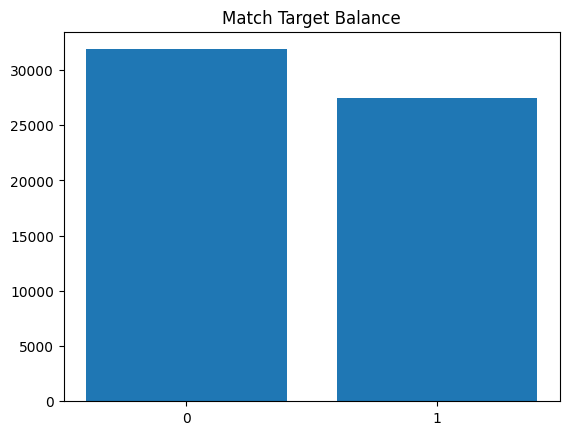

In [56]:
plt.bar(df2.label.unique(), df2.label.value_counts())
# make axis as discrete values
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Match Target Balance')
plt.show()

### Descriptive analysis

Even though we deal with texts, we should still use some descriptive analysis to get a better understanding of the data:

In [57]:
from bokeh.models import NumeralTickFormatter
# Word Frequency of most common words
word_freq = pd.Series(" ".join(df2["text"]).split()).value_counts().sort_values(ascending=False)
word_freq[1:50]

like        3115
new         3011
look        2839
color       2721
man         2715
trump       2550
old         2349
peopl       2308
get         2228
say         2221
time        2016
poster      1991
day         1923
woman       1880
take        1851
war         1845
life        1644
post        1595
world       1563
work        1526
go          1516
know        1502
american    1485
psbattl     1468
help        1438
state       1402
leav        1381
come        1377
think       1350
school      1333
save        1306
photo       1271
right       1254
hous        1254
circa       1246
presid      1234
want        1208
child       1207
way         1159
pictur      1158
give        1148
true        1125
dog         1103
friend      1098
polic       1078
make        1069
news        1064
tri         1051
home        1027
Name: count, dtype: int64

In [58]:
# list most uncommon words
word_freq[-10:].reset_index(name="freq")

,index,freq
0,marihuana,1
1,cryostat,1
2,cantor,1
3,revuls,1
4,atatiana,1
5,chandrashekhar,1
6,hulkmania,1
7,jingl,1
8,yoooou,1
9,wahr,1


In [59]:
# Distribution of ratings
df2.label.value_counts(normalize=True)

label
0    0.537249
1    0.462751
Name: proportion, dtype: float64

### Merge the functions
- pre-processing
- cleaning
- post-processing

#### Merge Preprocessing in one function
now we can combine all the above preprocessing methods in one

In [60]:
def pre_processing(df):
    df.drop_duplicates(inplace=True)
    return df

#### Merge Cleaning in one function
<!-- now we can combine all the above cleaning methods in two methods one for stemmer and one for lemmatizer -->
I was going to separate lemmatization and stemming but I thing doing lemma then stem will produce better data cleaning as I done above

##### Custom Cleaning

In [110]:
# def clean_text(df):
#     print("Cleaning and parsing the tweets...\n")
    
#     df.text = df.text.str.lower()
#     df.text = df.text.str.split(' ')
#     df.text = df.text.apply(removeSpecialCasesUDF)
#     df.text = df.text.apply(joinUDF)
#     df.text = df.text.apply(removePunctuationUDF)
#     df.text = df.text.str.split(' ')
#     df.text = df.text.apply(removeStopWordsUDF)
#     df.text = df.text.apply(lemmaUDF)
#     df.text = df.text.apply(stemUDF)
#     df.text = df.text.apply(joinUDF)

#     print("Done Cleaning and parsing the tweets.\n")
    
#     return df

##### Lab Cleaning

In [180]:
def clean_text(df):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    df.text = df.text.apply(lambda text: re.sub(RE_TAGS, " ", text))
    df.text = df.text.apply(lambda text: re.sub(RE_ASCII, " ", text))
    df.text = df.text.apply(lambda text: re.sub(RE_SINGLECHAR, " ", text))
    df.text = df.text.apply(lambda text: re.sub(RE_WSPACE, " ", text))

    df.text = df.text.apply(lambda text: word_tokenize(text))
    df.text = df.text.apply(lambda word_tokens: [word.lower() for word in word_tokens])
    df.text = df.text.apply(lambda words_tokens_lower: [stemmer.stem(word) for word in words_tokens_lower if word not in stopwords])
    df.text = df.text.apply(lambda words_filtered: " ".join(words_filtered))
    return df

##### With Stemmer

In [181]:
# def clean_text_stemmer(df):
#     print("Cleaning and parsing the tweets...\n")
    
#     df.text = df.text.str.lower()
#     df.text = df.text.str.split(' ')
#     # df.text = df.text.apply(removeSpecialCasesUDF)
#     df.text = df.text.apply(joinUDF)
#     df.text = df.text.apply(removePunctuationUDF)
#     df.text = df.text.str.split(' ')
#     df.text = df.text.apply(removeStopWordsUDF)
#     df.text = df.text.apply(stemUDF)
#     df.text = df.text.apply(joinUDF)

#     print("Done Cleaning and parsing the tweets.\n")
    
#     return df

In [182]:
# def clean_text_stemmer(text):
#     RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
#     RE_TAGS = re.compile(r"<[^>]+>")
#     RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
#     RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

#     text = re.sub(RE_TAGS, " ", text)
#     text = re.sub(RE_ASCII, " ", text)
#     text = re.sub(RE_SINGLECHAR, " ", text)
#     text = re.sub(RE_WSPACE, " ", text)

#     word_tokens = word_tokenize(text)
#     words_tokens_lower = [word.lower() for word in word_tokens]

#     words_filtered = [
#         stemmer.stem(word) for word in words_tokens_lower if word not in stopwords
#     ]

#     text_clean = " ".join(words_filtered)
#     return text_clean

##### With Lemmatizer

In [183]:
# def clean_text_lemmatizer(df):
#     print("Cleaning and parsing the tweets...\n")
    
#     df.text = df.text.str.lower()
#     df.text = df.text.str.split(' ')
#     # df.text = df.text.apply(removeSpecialCasesUDF)
#     df.text = df.text.apply(joinUDF)
#     df.text = df.text.apply(removePunctuationUDF)
#     df.text = df.text.str.split(' ')
#     df.text = df.text.apply(removeStopWordsUDF)
#     df.text = df.text.apply(lemmaUDF)
#     df.text = df.text.apply(joinUDF)

#     print("Done Cleaning and parsing the tweets.\n")
    
#     return df

In [184]:
# def clean_text_lemmatizer(text):
#     RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
#     RE_TAGS = re.compile(r"<[^>]+>")
#     RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
#     RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

#     text = re.sub(RE_TAGS, " ", text)
#     text = re.sub(RE_ASCII, " ", text)
#     text = re.sub(RE_SINGLECHAR, " ", text)
#     text = re.sub(RE_WSPACE, " ", text)

#     word_tokens = word_tokenize(text)
#     words_tokens_lower = [word.lower() for word in word_tokens]

#     words_filtered = [
#         lemmatize_word(word) for word in words_tokens_lower if word not in stopwords
#     ]

#     text_clean = " ".join(words_filtered)
#     return text_clean

#### Merge Post-Processing in one function
now we can combine all the above post-processing methods in one

In [185]:
def post_processing(df):
    df.drop_duplicates(inplace=True)
    return df

## Trails

My plan was to apply the trails on:
- count and tfidf vectorizer
- word and char analyzers
- stem and lemma cleaning
- xgboost and other models

but now I will apply:
- count and tfidf vectorizer
- word and char analyzers
- both stem and lemma cleaning
- xgboost and other models

I aleardy did like 7 trails 
- Trail 1 XGBoost stem
- Trail 2 Random Forest stem
- Trail 3 Linear Regression stem
- Trail 4 Decision Tree stem
- Trail 5 XGBoost lemma
- Trail 6 Naive Bayes lemma
- Trail 7 VotingClassifier lemma

but all I get is 85% training roc_auc and 78% testing roc_auc 

so I decided to change the plan to 4:4:2 instead of 4:3:3.

Really .....

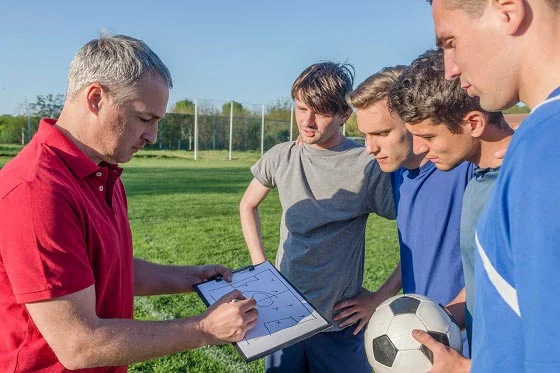

:D just kidding,

I will discuss each trail bellow

### First thing first Submission Generator :D

In [186]:
# calculate the score and store it in a csv file to submit it in kaggle
def saveScore(model, test_data, name):
    pred_test = model.predict_proba(test_data.text)[:,1]
    pred_df = pd.DataFrame(data={'id': test_data.id, 'label': pred_test})
    pred_df.to_csv(f'Adham Mokhtar {name}.csv', index=False)
    print(f'Done saving score for {name}')

### Prepaire Test data

#### Read Test Data

In [187]:
# Read raw data
test_data = pd.read_csv('x_test.csv')
test_data

,id,text
0,0,stargazer
1,1,yeah
2,2,PD: Phoenix car thief gets instructions from Y...
3,3,"As Trump Accuses Iran, He Has One Problem: His..."
4,4,"""Believers"" - Hezbollah 2011"
...,...,...
59146,59146,Bicycle taxi drivers of New Delhi
59147,59147,Trump blows up GOP's formula for winning House...
59148,59148,Napoleon returns from his exile on the island ...
59149,59149,Deep down he always wanted to be a ballet dancer


#### Clean Test Data
I already work on both stem and lemma separatly but I decided to work on both together.

In [188]:
df_test = test_data.copy()
df_test = clean_text(df_test)

In [189]:
# stem_df_test = test_data.copy()
# stem_df_test.text = stem_df_test.text.apply(clean_text_stemmer)
# stem_df_test = test_data.copy()
# stem_df_test = clean_text_stemmer(stem_df_test)

In [190]:
# lemma_df_test = test_data.copy()
# lemma_df_test.text = lemma_df_test.text.apply(clean_text_lemmatizer)
# lemma_df_test = test_data.copy()
# lemma_df_test = clean_text_lemmatizer(lemma_df_test)

#### Check Empty Values

In [191]:
(df_test.text.str.len() == 0).sum()

696

In [192]:
# (stem_df_test.text.str.len() == 0).sum()

In [193]:
# (lemma_df_test.text.str.len() == 0).sum()

#### Check Duplicated

In [194]:
df_test.text.duplicated().sum()

5716

In [195]:
# stem_df_test.text.duplicated().sum()

In [196]:
# lemma_df_test.text.duplicated().sum()

### Clean Training Data

In [197]:
df

,text,label
0,A group of friends began to volunteer at a hom...,0
1,British Prime Minister @Theresa_May on Nerve A...,0
2,"In 1961, Goodyear released a kit that allows P...",0
3,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0
...,...,...
59995,Finish Sniper Simo H盲yh盲 during the invasion o...,0
59996,Nigerian Prince Scam took $110K from Kansas ma...,1
59997,Is It Safe To Smoke Marijuana During Pregnancy...,0
59998,Julius Caesar upon realizing that everyone in ...,0


In [198]:
cleaned_df = df.copy()
cleaned_df = pre_processing(cleaned_df)
cleaned_df = clean_text(cleaned_df)
cleaned_df = post_processing(cleaned_df)
cleaned_df

,text,label
0,group friend began volunt homeless shelter nei...,0
1,british prime minist theresa nerv attack russi...,0
2,goodyear releas kit allow ps brought heel http...,0
3,happi birthday bob barker price right host lik...,0
4,obama nation innoc cop unarm young black men d...,0
...,...,...
59995,finish sniper simo yh invas finland ussr color,0
59996,nigerian princ scam took kansa man year later get,1
59997,safe smoke marijuana pregnanc surpris answer,0
59998,julius caesar realiz room knife bc,0


#### Data on Stemmer

In [199]:
# stem_df = df.copy()
# stem_df = pre_processing(stem_df)
# stem_df = clean_text_stemmer(stem_df)
# stem_df = post_processing(stem_df)
# stem_df

#### Data on Lemmetizer

In [200]:
# lemma_df = df.copy()
# lemma_df = pre_processing(lemma_df)
# lemma_df = clean_text_lemmatizer(lemma_df)
# lemma_df = post_processing(lemma_df)
# lemma_df

#### Check Similarity

In [201]:
# (lemma_df.text == stem_df.text).sum()

In [202]:
# (lemma_df.text != stem_df.text).sum()

### Split data to train and validation
using both lemma and stemandand

In [203]:
# Sample data - 05% of data to test set
# X_train_all, X_test, y_train_all, y_test = train_test_split(cleaned_df.text, cleaned_df.label, random_state=seed, test_size=0.05, stratify=cleaned_df.label, shuffle=True)

# now I will train the models with all the data after I already check the roc_auc for all the models below and they gave me training roc_auc around 85%
# and for testing around 78% so I will train with all the data before submit to kaggle, hoping the roc_auc increase
X_train_all = cleaned_df.text
y_train_all = cleaned_df.label

# split data to train and validation only (no test set)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, random_state=seed, test_size=0.05, stratify=y_train_all, shuffle=True)

X_test = X_val
y_test = y_val

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_train.index else 0 for x in X_train_all.index]

# Use the list to create PredefinedSplit
validation = PredefinedSplit(test_fold = split_index)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(56354,)
(2967,)
(2967,)


### Split stem data to train and validation

In [204]:
# # Sample data - 05% of data to test set
# s_X_train_all, s_X_test, s_y_train_all, s_y_test = train_test_split(stem_df.text, stem_df.label, random_state=seed, test_size=0.05, stratify=stem_df.label, shuffle=True)

# # now I will train the models with all the data after I already check the roc_auc for all the models below and they gave me training roc_auc around 85%
# # and for testing around 78% so I will train with all the data before submit to kaggle, hoping the roc_auc increase
# # s_X_train_all = stem_df.text
# # s_y_train_all = stem_df.label

# # split data to train and validation only (no test set)
# s_X_train, s_X_val, s_y_train, s_y_val = train_test_split(s_X_train_all, s_y_train_all, random_state=seed, test_size=0.05, stratify=s_y_train_all, shuffle=True)

# # s_X_test = s_X_val
# # s_y_test = s_y_val

# # Create a list where train data indices are -1 and validation data indices are 0
# split_index = [-1 if x in s_X_train.index else 0 for x in s_X_train_all.index]

# # Use the list to create PredefinedSplit
# stem_pds = PredefinedSplit(test_fold = split_index)

# print(s_X_train.shape)
# print(s_X_test.shape)
# print(s_X_val.shape)

---

***

### Split Lemma data to train and validation

In [205]:
# # Sample data - 05% of data to test set
# l_X_train_all, l_X_test, l_y_train_all, l_y_test = train_test_split(lemma_df.text, lemma_df.label, random_state=seed, test_size=0.05, stratify=lemma_df.label, shuffle=True)

# # now I will train the models with all the data after I already check the roc_auc for all the models below and they gave me training roc_auc around 85%
# # and for testing around 78% so I will train with all the data before submit to kaggle, hoping the roc_auc increase
# # l_X_train_all = lemma_df.text
# # l_y_train_all = lemma_df.label

# # split data to train and validation only (no test set)
# l_X_train, l_X_val, l_y_train, l_y_val = train_test_split(l_X_train_all, l_y_train_all, random_state=seed, test_size=0.05, stratify=l_y_train_all, shuffle=True)

# # l_X_test = l_X_val
# # l_y_test = l_y_val

# # Create a list where train data indices are -1 and validation data indices are 0
# split_index = [-1 if x in l_X_train.index else 0 for x in l_X_train_all.index]

# # Use the list to create PredefinedSplit
# lemma_pds = PredefinedSplit(test_fold = split_index)

# print(l_X_train.shape)
# print(l_X_test.shape)
# print(l_X_val.shape)

---

***

In [210]:
def fit(pipeline, parameters, X, y, validation):
    # Perform grid search with validation set
    model = GridSearchCV(pipeline, parameters, cv=validation, verbose=10, scoring="roc_auc", error_score='raise')
    model.fit(X, y)
    return model

In [211]:
def check_results(model):
    # Print the best hyperparameters and score
    print("Best parameters: ", model.best_params_)
    print("Best score: ", model.best_score_)

In [212]:
def check_reports(model, X_test, y_test):
    # run pipe with optimized parameters
    y_hat = model.predict(X_test)
    report = classification_report(y_test, y_hat)
    roc_auc = roc_auc_score(y_test, y_hat)
    print(f'classification report is: {report}')
    print(f'roc_auc is: {roc_auc}')

---

***

### 1. Trail - XGB tfidf Word
xgboost - TfidfVectorizer with word analyzer.

In [213]:
%time
# Create the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word')),
    ('classifier', XGBClassifier())
])

# Define the hyperparameters to tune
parameters = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
    'classifier__n_estimators': [800],
}

xgb_tf_word_gs = fit(pipeline, parameters, X_train_all, y_train_all, validation)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 1/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 1)
[CV 1/1; 1/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 1);, score=0.863 total time=  16.7s
[CV 1/1; 2/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 2)
[CV 1/1; 2/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 2);, score=0.840 total time=  37.2s
[CV 1/1; 3/6] START classifier__n_estimators=800, vectorizer__ngram_range=(2, 2)
[CV 1/1; 3/6] END classifier__n_estimators=800, vectorizer__ngram_range=(2, 2);, score=0.691 total time=  21.1s
[CV 1/1; 4/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 3)
[CV 1/1; 4/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 3);, score=0.825 total time=  59.5s
[CV 1/1; 5/6] START classifier__n_estimators=800, vectorizer__ngram_range=(2, 3)
[CV 1/1; 5/6] END classifier__n_estimators=800, v

In [214]:
check_results(xgb_tf_word_gs)

Best parameters:  {'classifier__n_estimators': 800, 'vectorizer__ngram_range': (1, 1)}
Best score:  0.8634539483002995


In [215]:
check_reports(xgb_tf_word_gs, X_test, y_test)

classification report is:               precision    recall  f1-score   support

           0       0.91      0.90      0.90      1594
           1       0.89      0.90      0.89      1373

    accuracy                           0.90      2967
   macro avg       0.90      0.90      0.90      2967
weighted avg       0.90      0.90      0.90      2967

roc_auc is: 0.8980497239740066


In [216]:
saveScore(xgb_tf_word_gs, df_test, 'XGBClassifier - tfidf - word')

Done saving score for XGBClassifier - tfidf - word


it seems that there is a slightly better performance than the usage of stem and lemma separatly.

the roc_auc increased by 1% in training :D

but it was decreasing when we increase the ngram range.

now lets try using another vectorizer and see what will happen.

---

***

### 2. Trail - XGB Count Word
xgboost - CountVectorizer with word analyzer.

In [217]:
%time
# Create the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word')),
    ('classifier', XGBClassifier())
])

# Define the hyperparameters to tune
parameters = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
    'classifier__n_estimators': [800],
}

xgb_count_word_gs = fit(pipeline, parameters, X_train_all, y_train_all, validation)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 1/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 1)
[CV 1/1; 1/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 1);, score=0.866 total time=   5.8s
[CV 1/1; 2/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 2)
[CV 1/1; 2/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 2);, score=0.868 total time=  24.9s
[CV 1/1; 3/6] START classifier__n_estimators=800, vectorizer__ngram_range=(2, 2)
[CV 1/1; 3/6] END classifier__n_estimators=800, vectorizer__ngram_range=(2, 2);, score=0.723 total time=  19.8s
[CV 1/1; 4/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 3)
[CV 1/1; 4/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 3);, score=0.867 total time=  46.3s
[CV 1/1; 5/6] START classifier__n_estimators=800, vectorizer__ngram_range=(2, 3)
[CV 1/1; 5/6] END classifier__n_estimators=800, v

In [218]:
check_results(xgb_count_word_gs)

Best parameters:  {'classifier__n_estimators': 800, 'vectorizer__ngram_range': (1, 2)}
Best score:  0.8676066750679214


In [219]:
check_reports(xgb_count_word_gs, X_test, y_test)

classification report is:               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1594
           1       0.84      0.86      0.85      1373

    accuracy                           0.86      2967
   macro avg       0.86      0.86      0.86      2967
weighted avg       0.86      0.86      0.86      2967

roc_auc is: 0.8600798149652602


In [220]:
saveScore(xgb_count_word_gs, df_test, 'XGBClassifier - count - word')

Done saving score for XGBClassifier - count - word


it seems that there is a slightly better performance than the usage of tfidf vectorizer.

the roc_auc increased by 1% in training :D

but it was increasing when we increase the ngram range (1, X).

so I will try one more time increasing the X more and more.

now lets try increasing the X and see what will happen.

---

***

### 3. Trail XGB Count Word count.
xgboost - CountVectorizer with word analyzer but with different hyper-parameter values.

In [221]:
%%time
# Create the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word')),
    ('classifier', XGBClassifier())
])

# Define the hyperparameters to tune
parameters = {
    'vectorizer__ngram_range': [(1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)],
    'classifier__n_estimators': [800],
}

xgb_count_word_gs2 = fit(pipeline, parameters, X_train_all, y_train_all, validation)

Fitting 1 folds for each of 7 candidates, totalling 7 fits
[CV 1/1; 1/7] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 4)
[CV 1/1; 1/7] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 4);, score=0.867 total time= 1.1min
[CV 1/1; 2/7] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 5)
[CV 1/1; 2/7] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 5);, score=0.867 total time= 1.4min
[CV 1/1; 3/7] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 6)
[CV 1/1; 3/7] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 6);, score=0.867 total time= 1.7min
[CV 1/1; 4/7] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 7)
[CV 1/1; 4/7] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 7);, score=0.867 total time= 1.9min
[CV 1/1; 5/7] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 8)
[CV 1/1; 5/7] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 8);, score=0

In [222]:
check_results(xgb_count_word_gs2)

Best parameters:  {'classifier__n_estimators': 800, 'vectorizer__ngram_range': (1, 4)}
Best score:  0.8665546143997748


In [223]:
check_reports(xgb_count_word_gs2, X_test, y_test)

classification report is:               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1594
           1       0.84      0.86      0.85      1373

    accuracy                           0.86      2967
   macro avg       0.86      0.86      0.86      2967
weighted avg       0.86      0.86      0.86      2967

roc_auc is: 0.8600293251916099


In [224]:
# will not save the predicitons

oooops, training with no purpose.

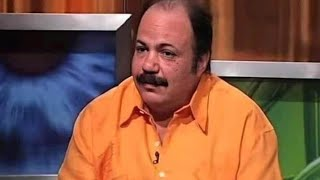

it seems that there is no improvment in the performance at all.

we just wasted our time, but no problem we can do more and more.

now lets try char analyzer with the tfidf vectorizer and see what will happen.

---

***

### 4. Trail XGB tfidf Char
xgboost - TfidfVectorizer with char analyzer.

In [225]:
%%time
# Create the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='char')),
    ('classifier', XGBClassifier())
])

# Define the hyperparameters to tune
parameters = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
    'classifier__n_estimators': [800],
}

xgb_tf_char_gs = fit(pipeline, parameters, X_train_all, y_train_all, validation)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 1/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 1)
[CV 1/1; 1/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 1);, score=0.580 total time=  38.6s
[CV 1/1; 2/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 2)
[CV 1/1; 2/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 2);, score=0.759 total time= 1.9min
[CV 1/1; 3/6] START classifier__n_estimators=800, vectorizer__ngram_range=(2, 2)
[CV 1/1; 3/6] END classifier__n_estimators=800, vectorizer__ngram_range=(2, 2);, score=0.762 total time= 1.4min
[CV 1/1; 4/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 3)
[CV 1/1; 4/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 3);, score=0.835 total time= 3.5min
[CV 1/1; 5/6] START classifier__n_estimators=800, vectorizer__ngram_range=(2, 3)
[CV 1/1; 5/6] END classifier__n_estimators=800, vectorizer__ngram_range=(2, 3);, score=0

In [226]:
check_results(xgb_tf_char_gs)

Best parameters:  {'classifier__n_estimators': 800, 'vectorizer__ngram_range': (3, 3)}
Best score:  0.8409652091190472


In [227]:
check_reports(xgb_tf_char_gs, X_test, y_test)

classification report is:               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1594
           1       0.97      0.98      0.98      1373

    accuracy                           0.98      2967
   macro avg       0.98      0.98      0.98      2967
weighted avg       0.98      0.98      0.98      2967

roc_auc is: 0.9797044817556002


In [228]:
saveScore(xgb_tf_char_gs, df_test, 'XGBClassifier - tfidf - char')

Done saving score for XGBClassifier - tfidf - char


it seems that there is no improvment in the training performance but there is an incredible imporvment in validation.

so now we can try count vectorizer hoping for better performance.

now lets try count vectorizer and see what will happen.

---

***

### 5. Trail XGB Count Char
xgboost - CountfVectorizer with char analyzer.

In [229]:
%%time
# Create the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char')),
    ('classifier', XGBClassifier())
])

# Define the hyperparameters to tune
parameters = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
    'classifier__n_estimators': [800],
}

xgb_cont_char_gs = fit(pipeline, parameters, X_train_all, y_train_all, validation)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 1/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 1)
[CV 1/1; 1/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 1);, score=0.573 total time=   8.2s
[CV 1/1; 2/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 2)
[CV 1/1; 2/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 2);, score=0.779 total time=  20.5s
[CV 1/1; 3/6] START classifier__n_estimators=800, vectorizer__ngram_range=(2, 2)
[CV 1/1; 3/6] END classifier__n_estimators=800, vectorizer__ngram_range=(2, 2);, score=0.779 total time=  15.6s
[CV 1/1; 4/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 3)
[CV 1/1; 4/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 3);, score=0.849 total time=  37.9s
[CV 1/1; 5/6] START classifier__n_estimators=800, vectorizer__ngram_range=(2, 3)
[CV 1/1; 5/6] END classifier__n_estimators=800, vectorizer__ngram_range=(2, 3);, score=0

In [230]:
check_results(xgb_cont_char_gs)

Best parameters:  {'classifier__n_estimators': 800, 'vectorizer__ngram_range': (3, 3)}
Best score:  0.8499224605014617


In [231]:
check_reports(xgb_cont_char_gs, X_test, y_test)

classification report is:               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1594
           1       0.94      0.95      0.95      1373

    accuracy                           0.95      2967
   macro avg       0.95      0.95      0.95      2967
weighted avg       0.95      0.95      0.95      2967

roc_auc is: 0.9496774594459741


In [232]:
saveScore(xgb_cont_char_gs, df_test, 'XGBClassifier - count - char')

Done saving score for XGBClassifier - count - char


it seems that there is no improvment in the training performance but there is an slightly imporvment in validation.

so as we see the score still increases so we can try another trail by increasing the hyper-paramerter values

now lets try increasing the ngram_range and see what will happen.

---

***

### 5. Trail XGB Count Char count.
xgboost - CountfVectorizer with char analyzer but with different hyper-parameter values.

In [233]:
%%time
# Create the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char')),
    ('classifier', XGBClassifier())
])

# Define the hyperparameters to tune
parameters = {
    'vectorizer__ngram_range': [(1, 4), (2, 4), (3, 4), (4, 4), (1, 5), (2, 5)],
    'classifier__n_estimators': [800],
}

xgb_cont_char_gs2 = fit(pipeline, parameters, X_train_all, y_train_all, validation)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[CV 1/1; 1/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 4)
[CV 1/1; 1/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 4);, score=0.858 total time=  57.5s
[CV 1/1; 2/6] START classifier__n_estimators=800, vectorizer__ngram_range=(2, 4)
[CV 1/1; 2/6] END classifier__n_estimators=800, vectorizer__ngram_range=(2, 4);, score=0.857 total time=  50.3s
[CV 1/1; 3/6] START classifier__n_estimators=800, vectorizer__ngram_range=(3, 4)
[CV 1/1; 3/6] END classifier__n_estimators=800, vectorizer__ngram_range=(3, 4);, score=0.861 total time=  37.7s
[CV 1/1; 4/6] START classifier__n_estimators=800, vectorizer__ngram_range=(4, 4)
[CV 1/1; 4/6] END classifier__n_estimators=800, vectorizer__ngram_range=(4, 4);, score=0.866 total time=  21.7s
[CV 1/1; 5/6] START classifier__n_estimators=800, vectorizer__ngram_range=(1, 5)
[CV 1/1; 5/6] END classifier__n_estimators=800, vectorizer__ngram_range=(1, 5);, score=0

In [234]:
check_results(xgb_cont_char_gs2)

Best parameters:  {'classifier__n_estimators': 800, 'vectorizer__ngram_range': (4, 4)}
Best score:  0.8659345725640855


In [235]:
check_reports(xgb_cont_char_gs2, X_test, y_test)

classification report is:               precision    recall  f1-score   support

           0       0.93      0.92      0.93      1594
           1       0.91      0.93      0.92      1373

    accuracy                           0.92      2967
   macro avg       0.92      0.92      0.92      2967
weighted avg       0.92      0.92      0.92      2967

roc_auc is: 0.9220771447187696


In [236]:
saveScore(xgb_cont_char_gs2, df_test, 'XGBClassifier - count - char 2')

Done saving score for XGBClassifier - count - char 2


it seems that there is a small imporovment in the training and decreasing in validation performance.

## Conclusion

As you can see, I tried many times but it seems that I'm trapped between 85% and 87% roc_auc with the XGBoost.